## Printing f1 CSV dataset

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
print("success")
# read csv file 
f1_results2018_df = pd.read_csv("Formula1_2018Season_RaceResults.csv")

f1_results2018_df.head(5)

# check data types of each variable
print(f1_results2018_df.dtypes)

success
Track            object
Position         object
No                int64
Driver           object
Team             object
Starting Grid     int64
Laps              int64
Time/Retired     object
Points            int64
Fastest Lap      object
dtype: object


### Visualization of Drivers per Team by Points 

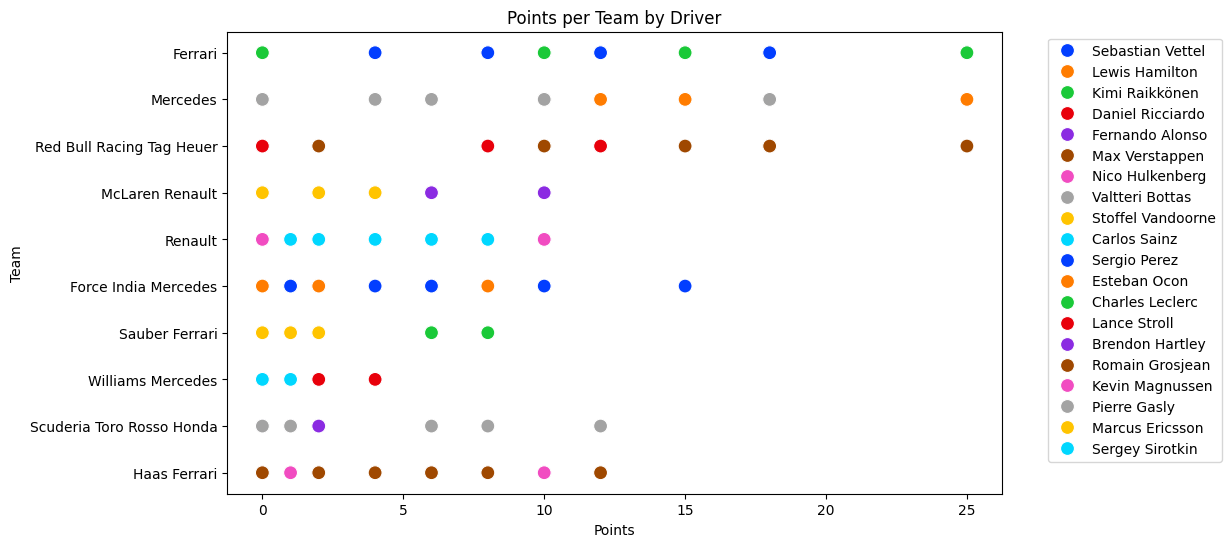

In [3]:

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=f1_results2018_df, x='Points', y='Team', hue='Driver', palette='bright', s=100)

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot title and labels
plt.title('Points per Team by Driver')
plt.xlabel('Points')
plt.ylabel('Team')

# Show plot
plt.show()


### Filtering Data to Points per Team and Points per Driver


In [4]:
# Points Per Team
team_points = f1_results2018_df.groupby('Team')['Points'].sum().reset_index()
team_points.columns = ['Team', 'total_points']

print(team_points)

# Total Points
total_points = team_points['total_points'].sum()
print("Total Points:", total_points)

# Points Per Driver
points_per_driver = f1_results2018_df.groupby('Driver')['Points'].sum().reset_index()
points_per_driver.columns = ['Driver', 'driver_points']

# Sort by Most points
points_per_driver = points_per_driver.sort_values(by= 'driver_points', ascending= False)
print(points_per_driver.head())


                        Team  total_points
0                    Ferrari           571
1       Force India Mercedes           111
2               Haas Ferrari            93
3            McLaren Renault            62
4                   Mercedes           655
5  Red Bull Racing Tag Heuer           419
6                    Renault           122
7             Sauber Ferrari            48
8  Scuderia Toro Rosso Honda            33
9          Williams Mercedes             7
Total Points: 2121
              Driver  driver_points
9     Lewis Hamilton            408
15  Sebastian Vettel            320
7     Kimi Raikkönen            251
11    Max Verstappen            249
19   Valtteri Bottas            247


### Performing a T-Test between 2 of the best teams

In [5]:
from scipy.stats import ttest_ind
# Points Per Driver and Team
points_per_driver_team = f1_results2018_df.groupby(['Driver', 'Team'])['Points'].sum().reset_index()
points_per_driver_team.columns = ['Driver', 'Team', 'driver_points']

# Filtering for Mercedes and Ferrarri
mercedes = points_per_driver_team[points_per_driver_team['Team'].str.contains('Mercedes')]
ferrari = points_per_driver_team[points_per_driver_team['Team'].str.contains('Ferrari')]

# Perform t-test (default significance level .05)
t_stat, p_value = ttest_ind(mercedes['driver_points'], ferrari['driver_points'])

print(f"T-Stat: {t_stat}")
print(f"P-Value: {p_value}")


T-Stat: 0.11840286044910289
P-Value: 0.9080930883982303


## 1 Sample Proportion Test to see if Mercedes has 50% or more of the best lap per track

In [6]:

# Function to convert lap time string to seconds
def lap_time_to_seconds(lap_time):
    try:
        minutes, seconds = lap_time.split(':')
        return int(minutes) * 60 + float(seconds)
    except AttributeError:
        return None

# Convert 'Fastest Lap' to seconds
f1_results2018_df['Fastest Lap'] = f1_results2018_df['Fastest Lap'].apply(lap_time_to_seconds)

# Group by Track and find the best lap time for each track
best_lap_per_track = f1_results2018_df.groupby('Track')['Fastest Lap'].min()

# Count the number of tracks where Mercedes has the best lap time
# Select only the columns you want to apply the function to after groupby
mercedes_best_lap_count = (f1_results2018_df[f1_results2018_df['Team'] == 'Mercedes']
                           .groupby('Track')['Fastest Lap']
                           .min()
                           .reset_index(drop=True)
                           .count())

# Total number of tracks
total_tracks = best_lap_per_track.count()

# Perform one-sample proportion test using proportions_ztest
count = mercedes_best_lap_count
nobs = total_tracks
value = 0.5  # Expected proportion under the null hypothesis
alternative = 'larger'

# Calculate proportion and standard error
proportion = count / nobs
standard_error = np.sqrt(proportion * (1 - proportion) / nobs)

# Calculate confidence interval
z_critical = np.abs(stats.norm.ppf(0.025))  # For a 95% confidence interval
margin_of_error = z_critical * standard_error
confidence_interval = (proportion - margin_of_error, proportion + margin_of_error)

# Perform the z-test
z_stat, p_value = proportions_ztest(count, nobs, value, alternative=alternative)

print("Test Statistic (Z):", z_stat)
print("Standard Error:", standard_error)
print("Confidence Interval:", confidence_interval)
print("P-value:", p_value)

# Check for significance at alpha = 0.05
if p_value < 0.05:
    print("Mercedes has significantly more than 50% of the best lap times per track.")
else:
    print("Mercedes does not have significantly more than 50% of the best lap times per track.")




Test Statistic (Z): inf
Standard Error: 0.0
Confidence Interval: (1.0, 1.0)
P-value: 0.0
Mercedes has significantly more than 50% of the best lap times per track.


/mnt/c/Users/melme/Coding Portfolio/.venv/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std
